In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pysal as ps

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings('ignore')

C:\Users\schif\anaconda3\envs\spatial\lib\site-packages\pysal\explore\segregation\network\network.py:15: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  warn(


In [2]:
food = gpd.read_file("../../data/geojson/food_consumption_msoa.geojson").to_crs('EPSG:27700')
food.head(2)

id  age_0_17  age_18_64  age_65+   alcohol  alcohol_ci95  \
0  E02000001    1018.0     4349.0   1320.0  0.340733      0.004482   
1  E02000002    2150.0     4151.0   1078.0  0.180770      0.013925   

   alcohol_perc2.5  alcohol_perc25  alcohol_perc50  alcohol_perc75  ...  \
0              0.0             0.0             0.0             0.0  ...   
1              0.0             0.0             0.0             0.0  ...   

   volume_std      weight  weight_ci95  weight_perc2.5  weight_perc25  \
0   78.221175  323.180804     1.001360            35.0          150.0   
1  116.201057  397.651232     6.030232            32.5          150.0   

   weight_perc50  weight_perc75  weight_perc97.5  weight_std  \
0          250.0          400.0           1000.0  323.685705   
1          300.0          500.0           1020.0  550.434424   

                                            geometry  
0  MULTIPOLYGON (((532135.146 182198.119, 532158....  
1  POLYGON ((548881.564 190845.265, 548881.126 19...  

[2 rows x 222 columns]

In [3]:
food.crs

<Projected CRS: EPSG:27700>
Name: OSGB 1936 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: UK - Britain and UKCS 49°46'N to 61°01'N, 7°33'W to 3°33'E
- bounds: (-9.2, 49.75, 2.88, 61.14)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: OSGB 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [4]:
food.columns.values

array(['id', 'age_0_17', 'age_18_64', 'age_65+', 'alcohol',
       'alcohol_ci95', 'alcohol_perc2.5', 'alcohol_perc25',
       'alcohol_perc50', 'alcohol_perc75', 'alcohol_perc97.5',
       'alcohol_std', 'apprenticeship', 'apprenticeship_p', 'area_sq_km',
       'avg_age', 'avg_age_norm', 'carb', 'carb_ci95', 'carb_perc2.5',
       'carb_perc25', 'carb_perc50', 'carb_perc75', 'carb_perc97.5',
       'carb_std', 'energy_alcohol', 'energy_alcohol_ci95',
       'energy_alcohol_perc2.5', 'energy_alcohol_perc25',
       'energy_alcohol_perc50', 'energy_alcohol_perc75',
       'energy_alcohol_perc97.5', 'energy_alcohol_std', 'energy_carb',
       'energy_carb_ci95', 'energy_carb_perc2.5', 'energy_carb_perc25',
       'energy_carb_perc50', 'energy_carb_perc75', 'energy_carb_perc97.5',
       'energy_carb_std', 'energy_density', 'energy_fat',
       'energy_fat_ci95', 'energy_fat_perc2.5', 'energy_fat_perc25',
       'energy_fat_perc50', 'energy_fat_perc75', 'energy_fat_perc97.5',
       'ene

In [5]:
W_q = ps.lib.weights.Queen.from_dataframe(food)
W_q

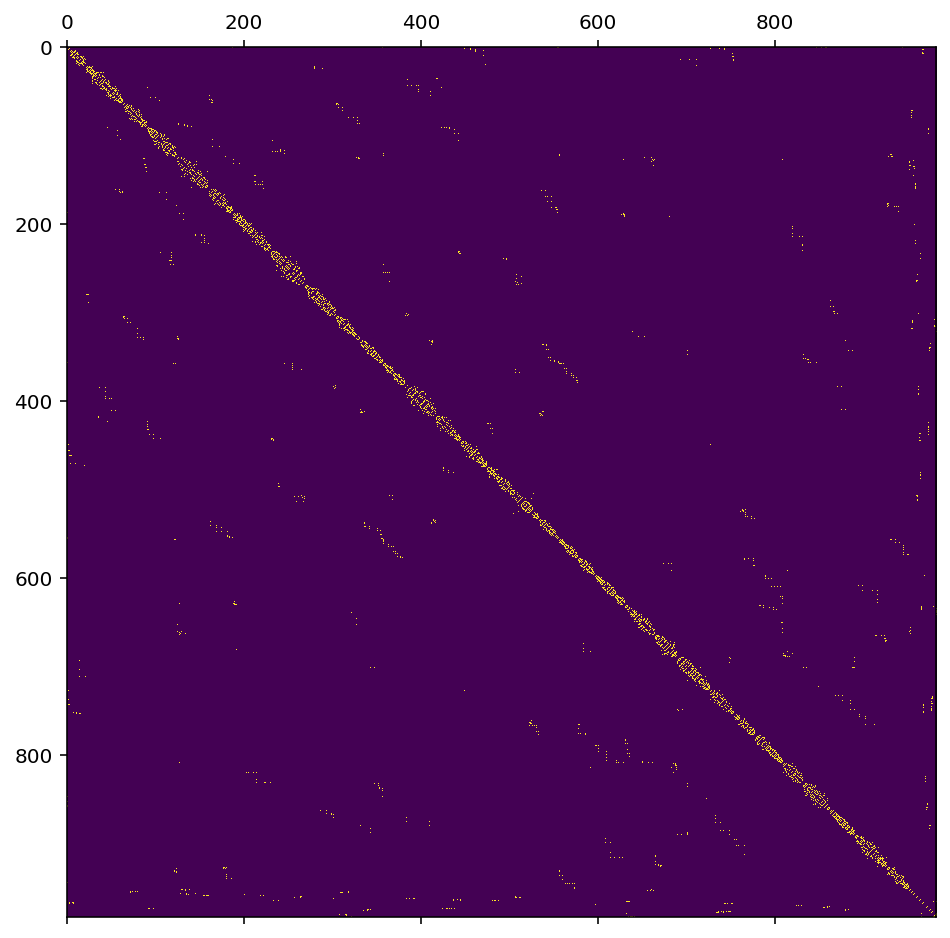

In [6]:
f, ax = plt.subplots(figsize=(8,8))
ax.matshow(W_q.sparse.todense())

In [7]:
def plot_weights(W, df, title=None):
    
    f, ax = plt.subplots(figsize=(8,8))
    ax.axis('off')
    if title:
        ax.set_title(title)
    
    df.plot(ax = ax, facecolor = 'gray', alpha= 0.3)
    W.plot(
            df, 
            edge_kws=dict(linewidth=1, color='orangered'), 
            node_kws=dict(s=0), 
            ax = ax)

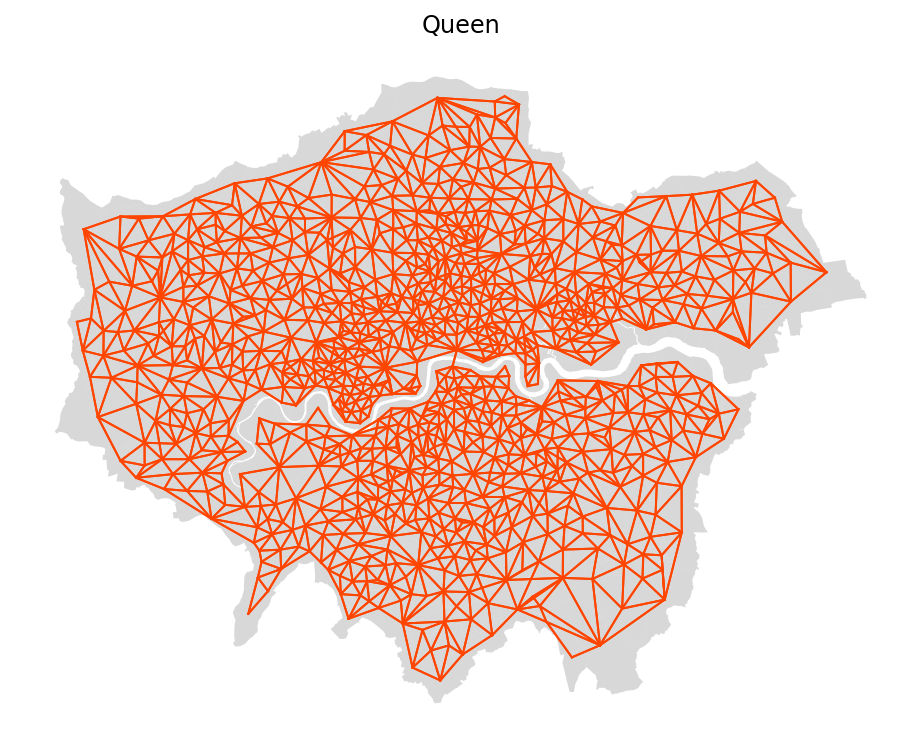

In [8]:
plot_weights(W_q, food, title='Queen')

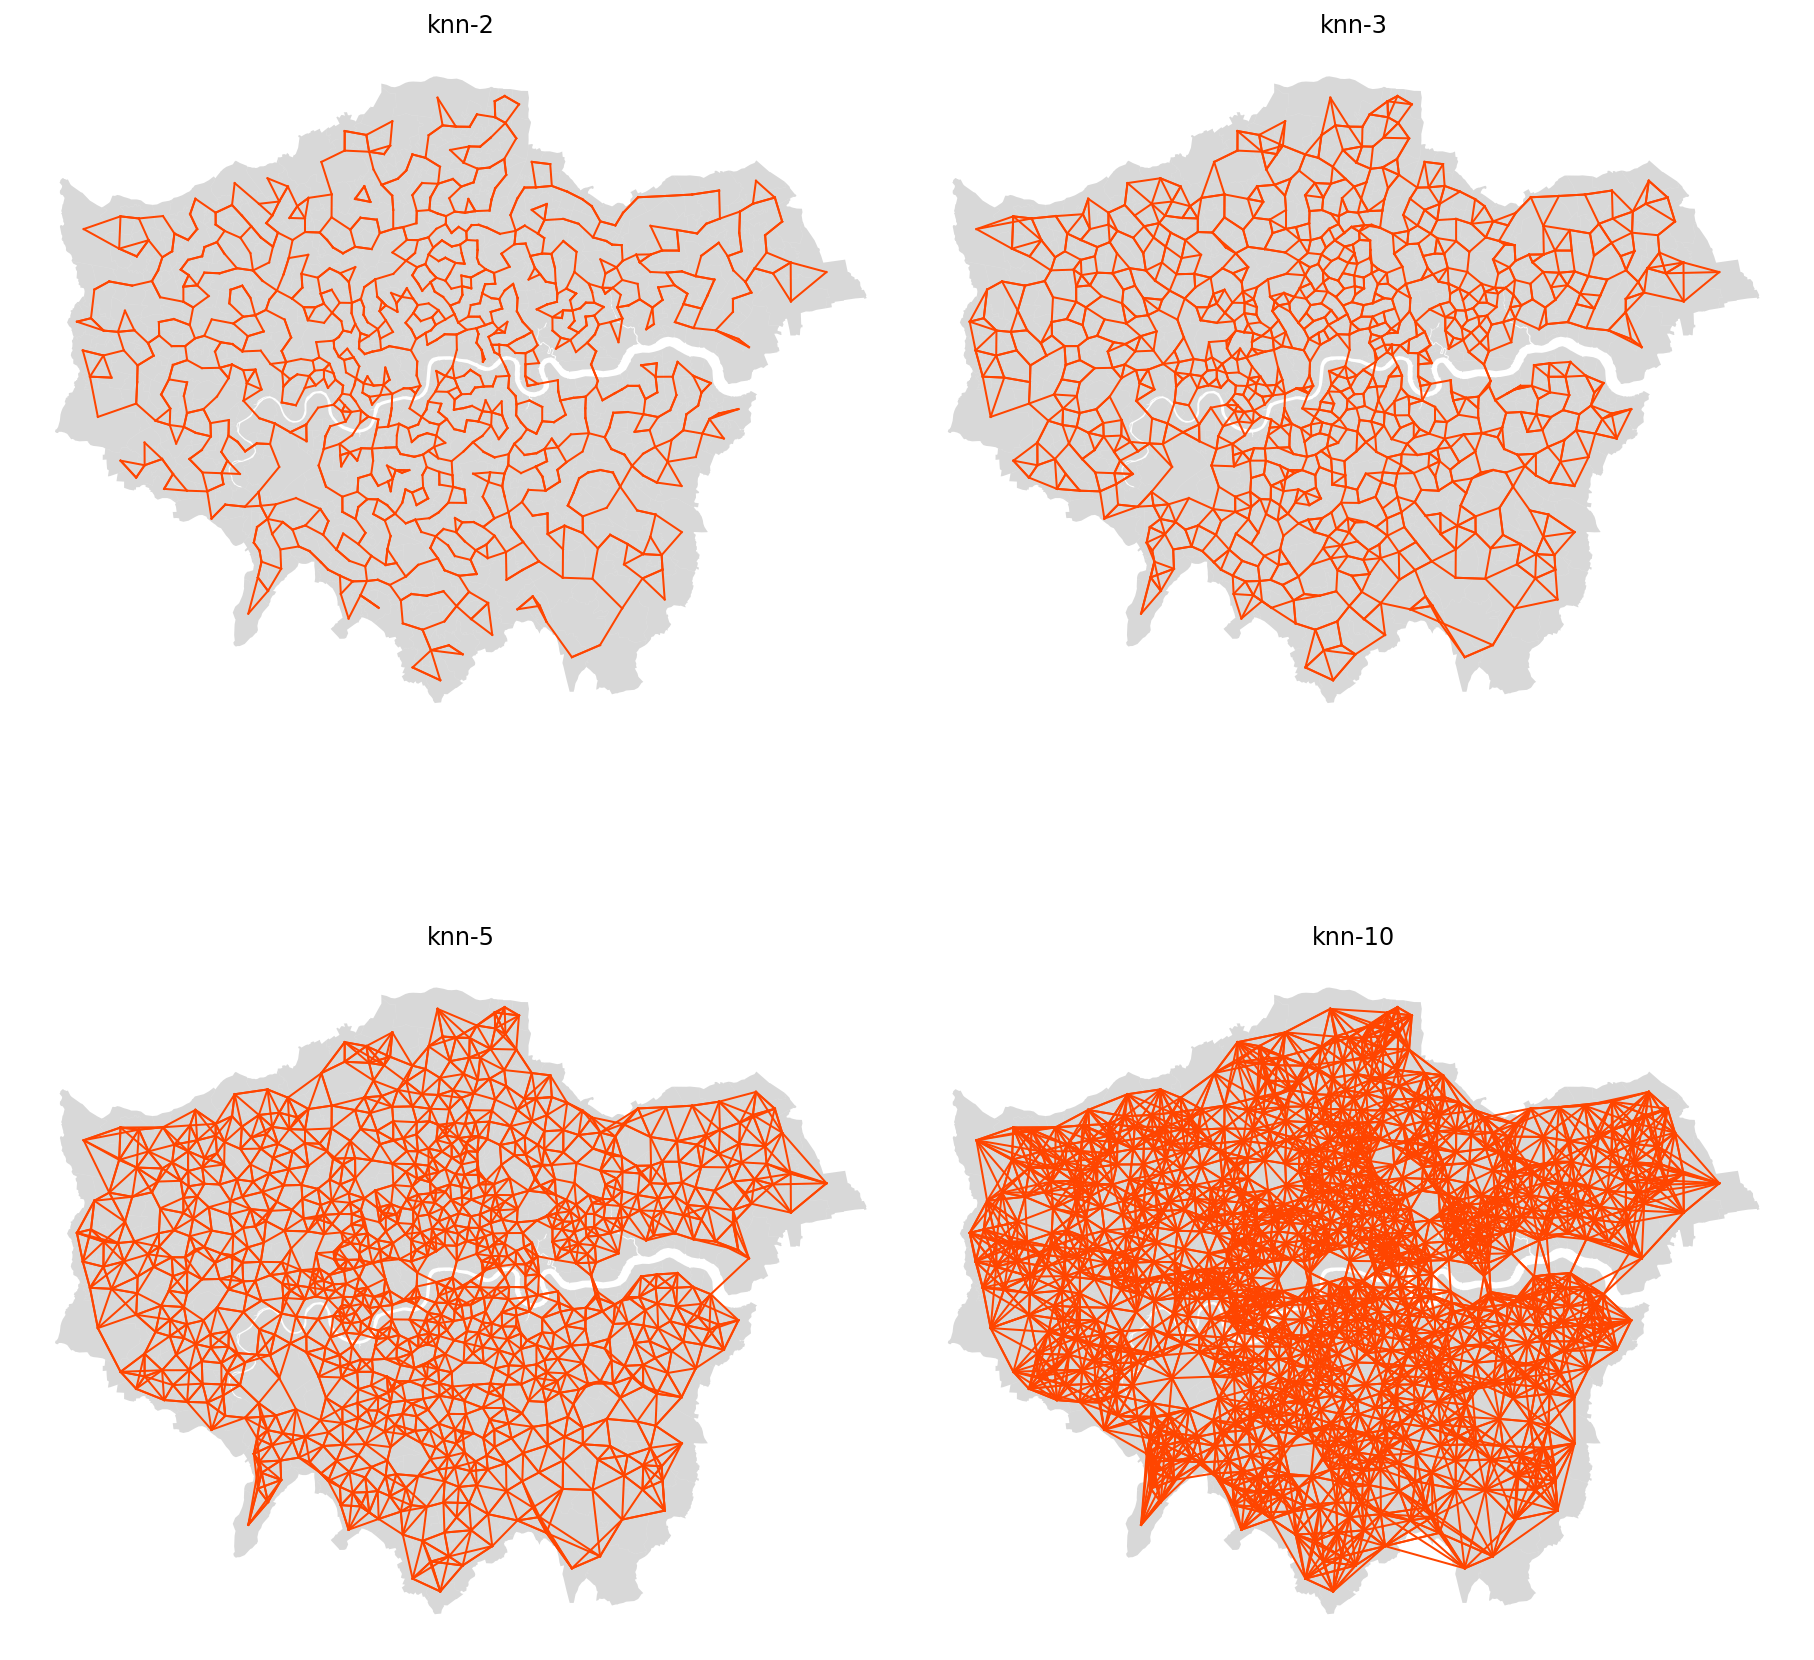

In [9]:
from matplotlib import gridspec

fig = plt.figure(figsize=(16,16)) 

gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1]) 
gs.update(wspace=0.0, hspace=0.1)

plt.axis('equal')

i=0
for k in [2,3,5,10]:
    W_knn = ps.lib.weights.KNN.from_dataframe(food, k=k)
    
    ax = plt.subplot(gs[i])
    ax.axis('off')
    ax.set_title('knn-'+str(k))
    
    food.plot(ax = ax, facecolor = 'gray', alpha= 0.3)
    W_knn.plot(
            food, 
            edge_kws=dict(linewidth=1, color='orangered'), 
            node_kws=dict(s=0), 
            ax = ax)

    i+=1

(<Figure size 720x720 with 1 Axes>, <AxesSubplot:>)

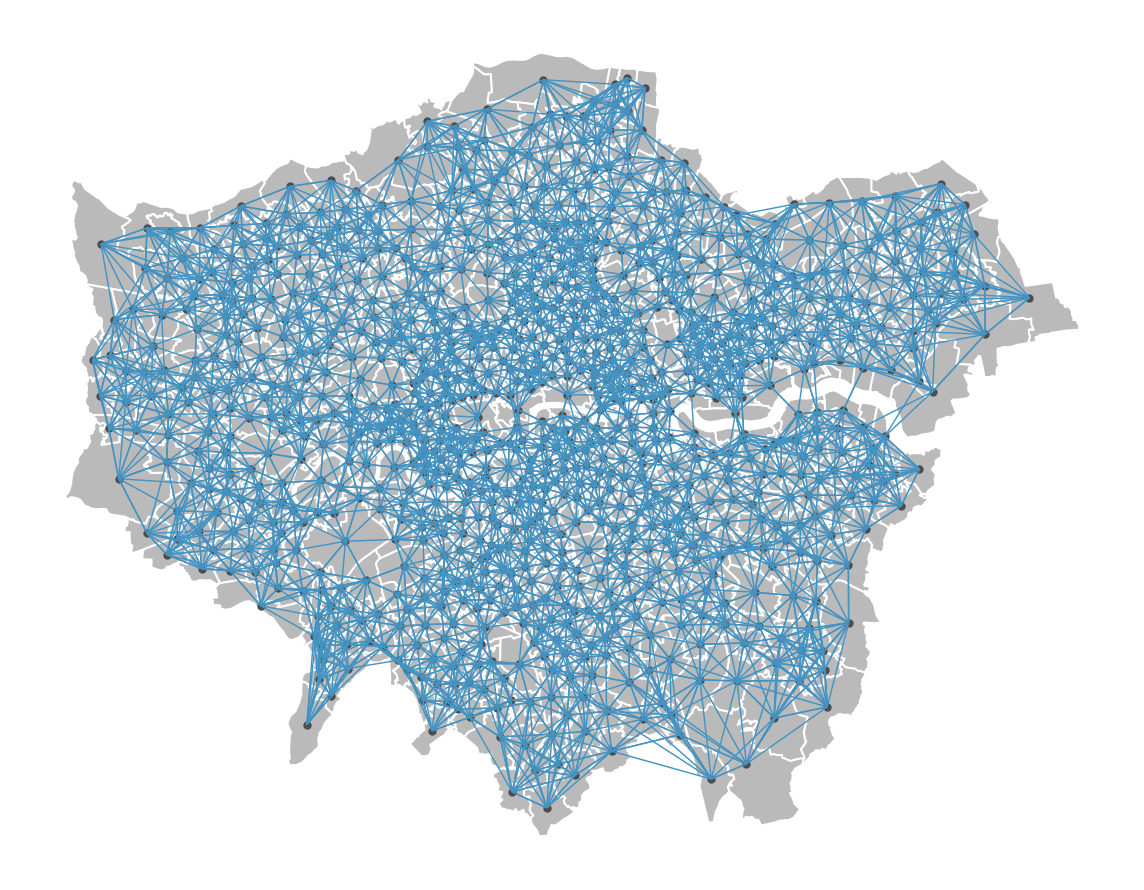

In [11]:
from splot.libpysal import plot_spatial_weights

Wkernel_adaptive_gaussian = ps.lib.weights.Kernel.from_dataframe(food, 
                                                                 k = 10, 
                                                                 fixed=False, 
                                                                 function='triangular')

plot_spatial_weights(Wkernel_adaptive_gaussian, food)

<AxesSubplot:>

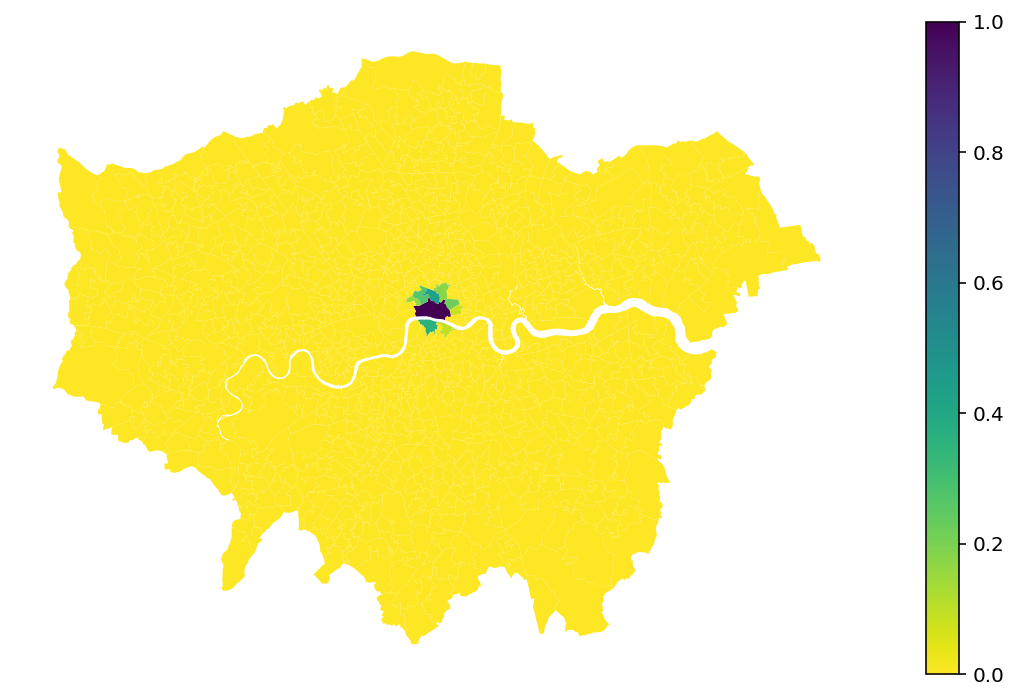

In [12]:
f, ax = plt.subplots(figsize=(12,6))
ax.axis('off')
food.assign(weights=Wkernel_adaptive_gaussian.sparse[0,:].toarray().flatten())\
    .plot('weights', cmap='viridis_r', ax = ax, legend=True)

In [13]:
import esda 

carb_I = esda.moran.Moran(food['carb'], W_q, permutations=10000)
carb_I.p_sim, carb_I.I, carb_I.EI

(9.999000099990002e-05, 0.6786682382799877, -0.0010183299389002036)

(<Figure size 504x504 with 1 Axes>,
 <AxesSubplot:title={'center':'Moran Scatterplot (0.68)'}, xlabel='Attribute', ylabel='Spatial Lag'>)

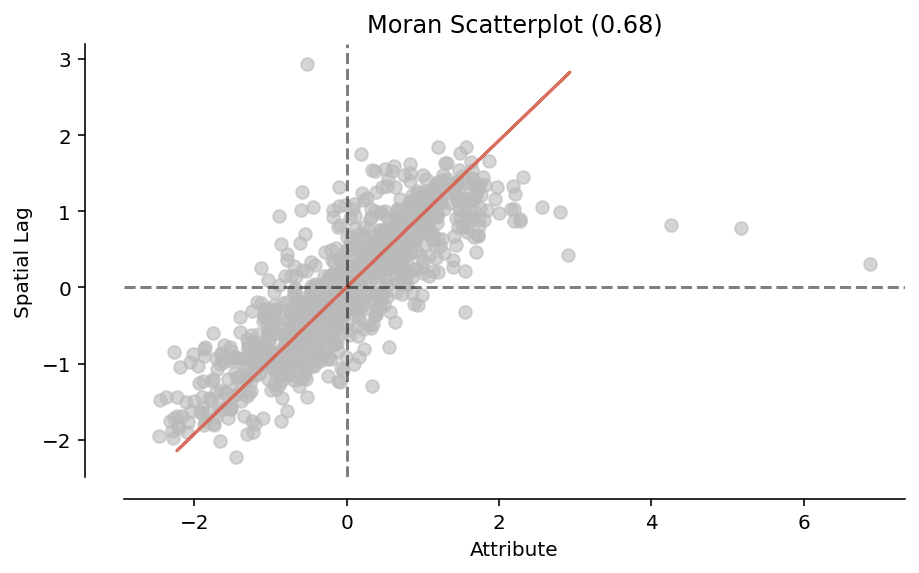

In [14]:
from splot.esda import moran_scatterplot

moran_scatterplot(carb_I)

(<Figure size 720x288 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Reference Distribution'}, xlabel='Moran I: 0.68', ylabel='Density'>,
        <AxesSubplot:title={'center':'Moran Scatterplot (0.68)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
       dtype=object))

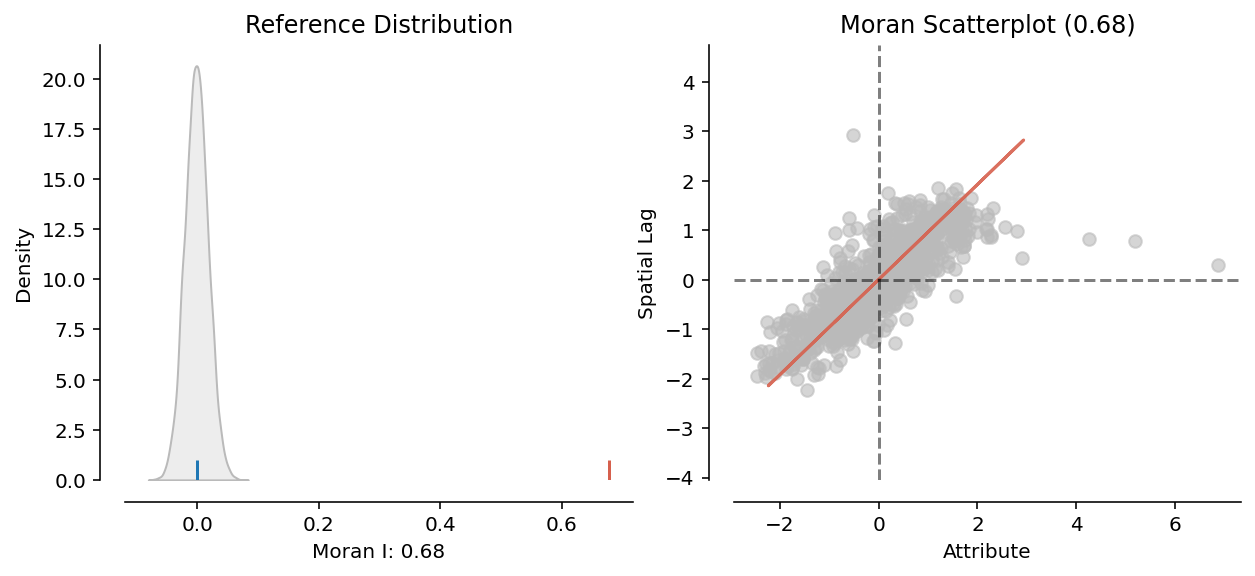

In [15]:
from splot.esda import plot_moran

plot_moran(carb_I)

In [16]:
carb_I_l = esda.moran.Moran_Local(food['carb'], W_q)

In [17]:
carb_I_l.Is[:10], carb_I_l.p_sim[:10]

(array([1.44813856, 0.72923218, 1.59807451, 1.4442929 , 1.41156126,
        1.3048487 , 0.94536102, 1.00570287, 0.55720755, 0.91832143]),
 array([0.002, 0.036, 0.013, 0.009, 0.012, 0.025, 0.014, 0.011, 0.026,
        0.016]))

(<Figure size 720x720 with 1 Axes>, <AxesSubplot:>)

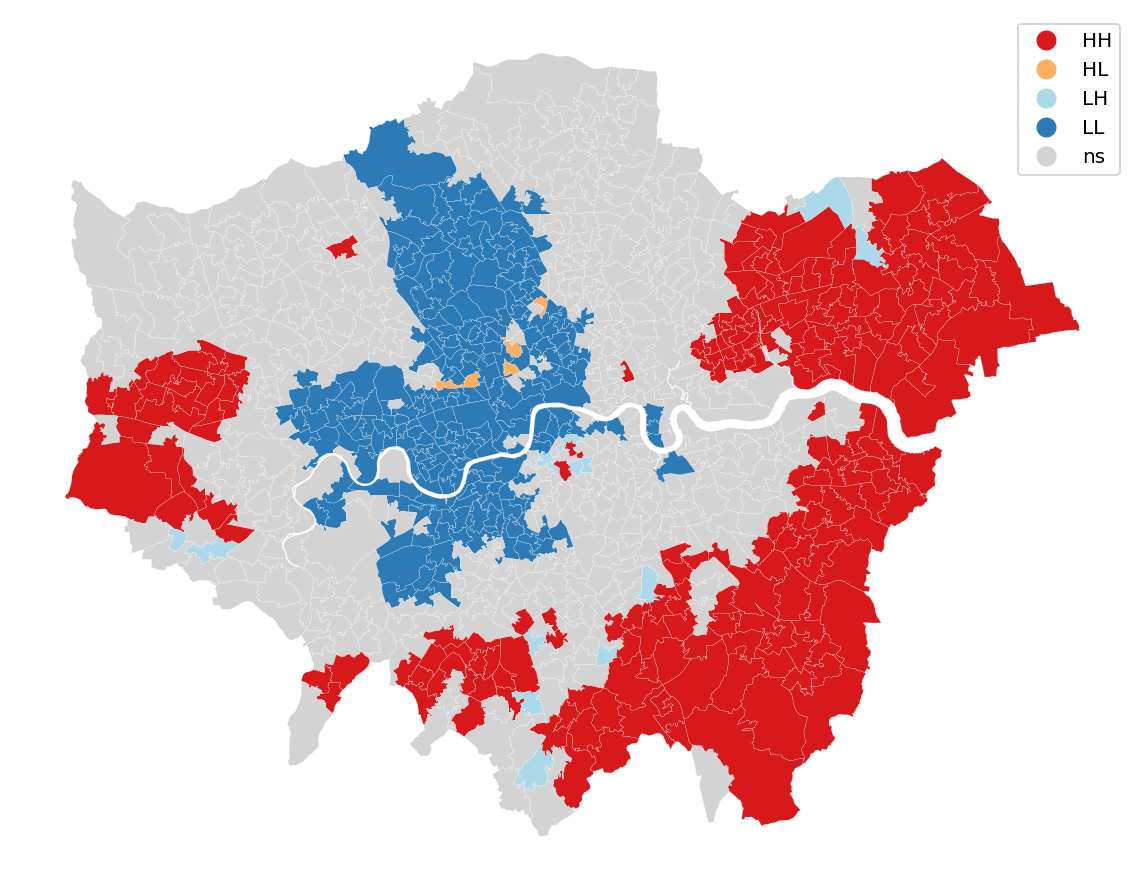

In [18]:
from splot.esda import lisa_cluster

lisa_cluster(carb_I_l, food, figsize=(10,10))

(<Figure size 1080x288 with 3 Axes>,
 array([<AxesSubplot:title={'center':'Moran Local Scatterplot'}, xlabel='Attribute', ylabel='Spatial Lag'>,
        <AxesSubplot:>, <AxesSubplot:>], dtype=object))

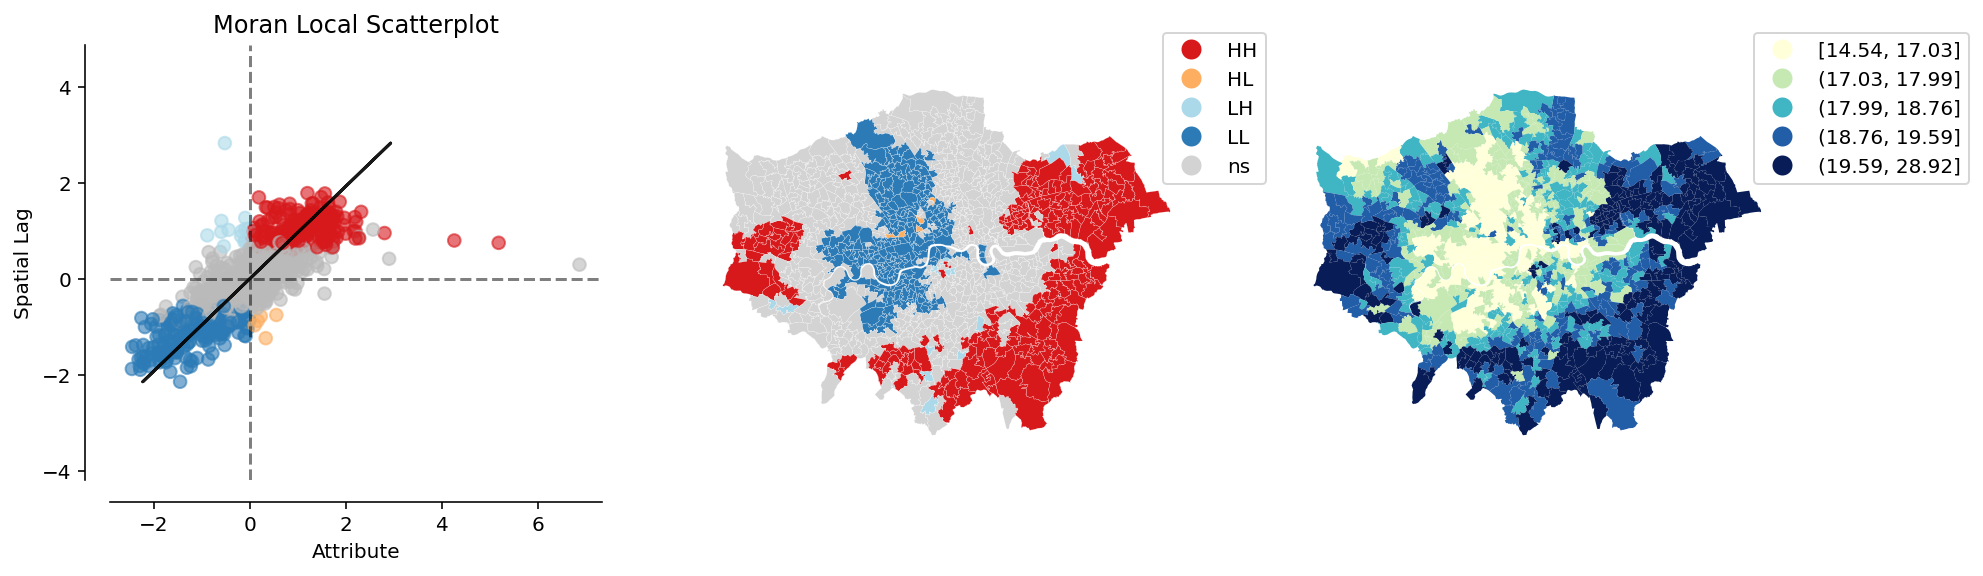

In [19]:
from splot.esda import plot_local_autocorrelation

plot_local_autocorrelation(carb_I_l, food, 'carb')

(<Figure size 1152x864 with 16 Axes>,
 array([[<AxesSubplot:ylabel='Spatial Lag of fat'>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:ylabel='Spatial Lag of protein'>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:ylabel='Spatial Lag of fibre'>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:xlabel='fat', ylabel='Spatial Lag of carb'>,
         <AxesSubplot:xlabel='protein'>, <AxesSubplot:xlabel='fibre'>,
         <AxesSubplot:xlabel='carb'>]], dtype=object))

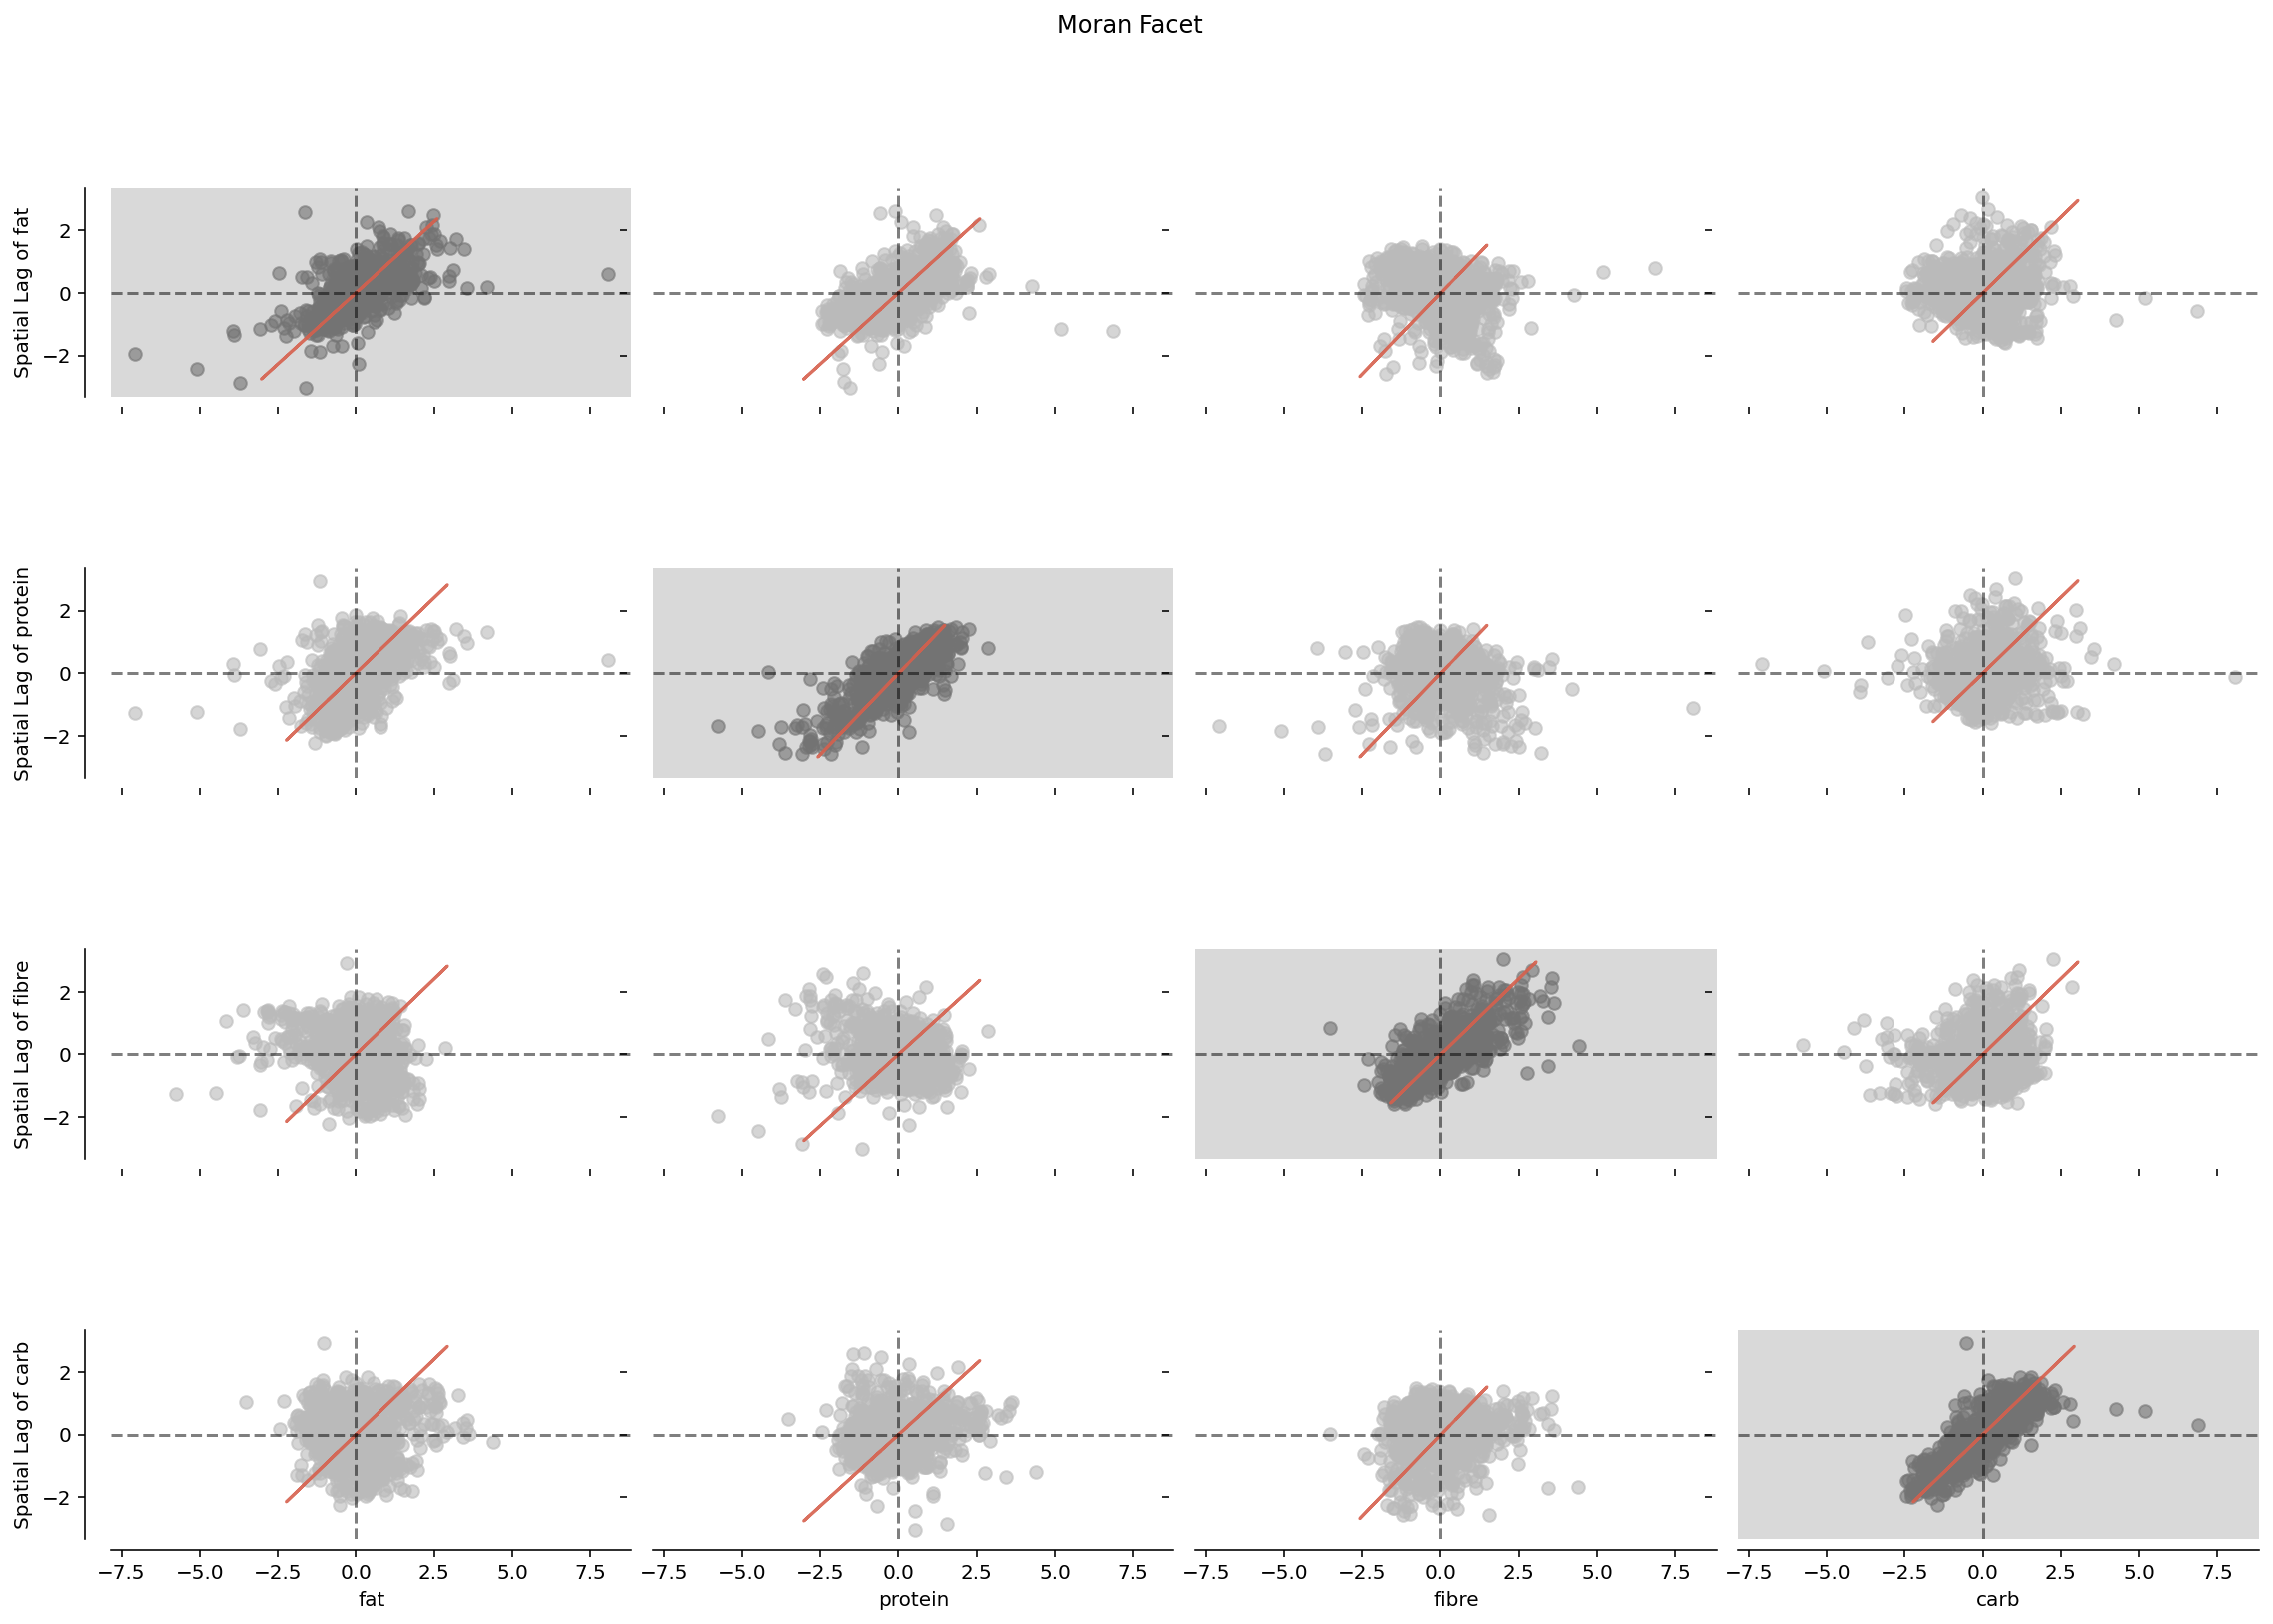

In [20]:
from esda.moran import Moran_BV_matrix
from splot.esda import moran_facet

nutrients = ['carb', 'fat', 'protein', 'fibre']

values = [np.array(food[var].values) for var in nutrients]

moran_matrix = Moran_BV_matrix(values,  W_q,  varnames = nutrients)
moran_facet(moran_matrix)